In [3]:
pip install transformers torch pandas scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install accelerate -U

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for accelerate from https://files.pythonhosted.org/packages/5f/a0/d9ef19f780f319c21ee90ecfef4431cbeeca95bec7f14071785c17b6029b/accelerate-1.10.1-py3-none-any.whl.metadata
  Obtaining dependency information for huggingface_hub>=0.21.0 from https://files.pythonhosted.org/packages/39/7b/bb06b061991107cd8783f300adff3e7b7f284e330fd82f507f2a1417b11d/huggingface_hub-0.34.4-py3-none-any.whl.metadata
  Obtaining dependency information for safetensors>=0.4.3 from https://files.pythonhosted.org/packages/2c/c3/c0be1135726618dc1e28d181b8c442403d8dbb9e273fd791de2d4384bcdd/safetensors-0.6.2-cp38-abi3-win_amd64.whl.metadata
  Obtaining dependency information for fsspec>=2023.5.0 from https://files.pythonhosted.org/packages/2f/e0/014d5d9d7a4564cf1c40b5039bc882db69fd881111e03ab3657ac0b218e2/fsspec-2025.7.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/374.9 kB ? et

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2023.4.0 requires fsspec==2023.4.0, but you have fsspec 2025.7.0 which is incompatible.


In [10]:
# Instal library yang diperlukan
import sys
import subprocess

# Install required packages
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    
install('accelerate>=0.20.1')
install('datasets')

import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Load data training
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Preprocessing sederhana
def clean_text(text):
    text = str(text).lower()
    text = ' '.join([word for word in text.split() if not word.startswith('@')])
    text = ' '.join([word for word in text.split() if not word.startswith('#')])
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Encode label
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])

# Split data training
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['clean_text'].tolist(),
    train_df['label_encoded'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=train_df['label_encoded']
)

# Pilih model
model_name = "cahya/bert-base-indonesian-522M"

# Load tokenizer dan model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=8,  # Sesuaikan dengan jumlah pilar Astacita
    id2label={i: label for i, label in enumerate(le.classes_)},
    label2id={label: i for i, label in enumerate(le.classes_)}
)

# Custom Dataset
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Buat dataset
train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer)

# Buat DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Setup optimizer dan scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 5  # 5 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}')
    
    # Validation
    model.eval()
    val_loss = 0
    correct_predictions = 0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            val_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_predictions.double() / len(val_dataset)
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

# Simpan model
model.save_pretrained("indonesian-astacita-classifier")
tokenizer.save_pretrained("indonesian-astacita-classifier")

# Prediksi di test data
test_dataset = TweetDataset(
    test_df['clean_text'].tolist(),
    [-1]*len(test_df),  # Dummy label
    tokenizer
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

test_df['label'] = le.inverse_transform(all_preds)

# Simpan hasil
test_df[['id', 'text', 'label']].to_csv('test_predictions.csv', index=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 250/250 [55:06<00:00, 13.23s/it, loss=1.33] 


Epoch 1/5, Average Training Loss: 1.4978
Validation Loss: 1.2490, Accuracy: 0.5900


Epoch 2/5: 100%|██████████| 250/250 [49:43<00:00, 11.93s/it, loss=0.743]


Epoch 2/5, Average Training Loss: 0.9939
Validation Loss: 1.1911, Accuracy: 0.6270


Epoch 3/5: 100%|██████████| 250/250 [50:06<00:00, 12.02s/it, loss=0.773]


Epoch 3/5, Average Training Loss: 0.7572
Validation Loss: 1.2338, Accuracy: 0.6390


Epoch 4/5: 100%|██████████| 250/250 [46:15<00:00, 11.10s/it, loss=0.626] 


Epoch 4/5, Average Training Loss: 0.5386
Validation Loss: 1.3140, Accuracy: 0.6380


Epoch 5/5: 100%|██████████| 250/250 [46:44<00:00, 11.22s/it, loss=0.388] 


Epoch 5/5, Average Training Loss: 0.3981
Validation Loss: 1.3523, Accuracy: 0.6340


Classification Report:
              precision    recall  f1-score   support

     harmoni       0.75      0.68      0.72       133
  hilirisasi       0.36      0.41      0.38        37
    ideologi       0.69      0.73      0.71       244
   pekerjaan       0.49      0.38      0.43        69
  pemerataan       0.38      0.41      0.40        61
  pertahanan       0.77      0.80      0.79       214
   reformasi       0.50      0.52      0.51       154
         sdm       0.61      0.52      0.56        88

    accuracy                           0.63      1000
   macro avg       0.57      0.56      0.56      1000
weighted avg       0.63      0.63      0.63      1000



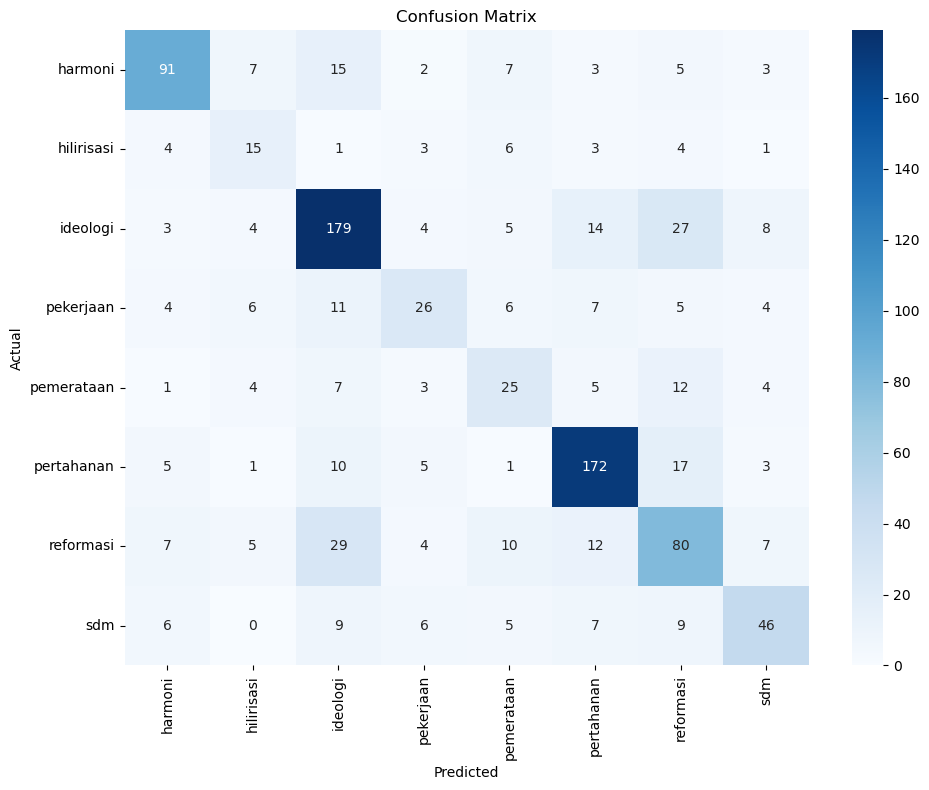


Jumlah prediksi yang salah: 366 dari 1000 data validasi

Contoh prediksi yang salah:
Text: efek brain rot di indonesia diskusi publik jdi ajang saling serang bukan saling pahami polarisasi ma...
True Label: ideologi, Predicted: sdm

Text: mgkin klo dapat kyk posisi dirut mungkin lebih banyak beternak selir itu kades.persetan ama pembangu...
True Label: reformasi, Predicted: pemerataan

Text: kejagung gandeng operator telekomunikasi atas nama intelijen hukum. efektif untuk penegakan hukum ta...
True Label: pertahanan, Predicted: reformasi

Text: ini hoaks bukan sih? presiden baru2 ini mengatakan angka pengangguran dan kemiskinan turun. piye tok...
True Label: pekerjaan, Predicted: hilirisasi

Text: eh.. anjai ini negara demokraasi kaga ada kebebasan berekspresi anjai knp pula lo pada milih preside...
True Label: harmoni, Predicted: ideologi

Text: iya ga boleh sembarangan kasih tau data pribadi apalagi jam lahir kita trus weton juga karena kita k...
True Label: pertahanan, Predicted: r

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Evaluasi model pada data validasi dengan metrik lengkap
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Konversi ke label asli
y_true = le.inverse_transform(all_labels)
y_pred = le.inverse_transform(all_preds)

# Tampilkan classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=le.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Analisis contoh prediksi yang salah
error_indices = np.where(np.array(all_preds) != np.array(all_labels))[0]
print(f"\nJumlah prediksi yang salah: {len(error_indices)} dari {len(all_labels)} data validasi")

# Tampilkan 10 contoh prediksi yang salah
print("\nContoh prediksi yang salah:")
for idx in error_indices[:10]:
    text = val_texts[idx]
    true_label = le.classes_[all_labels[idx]]
    pred_label = le.classes_[all_preds[idx]]
    print(f"Text: {text[:100]}...")
    print(f"True Label: {true_label}, Predicted: {pred_label}\n")

# Tampilkan 5 contoh prediksi yang benar untuk setiap kelas
print("\nContoh prediksi yang benar untuk setiap kelas:")
for label in le.classes_:
    label_indices = np.where(np.array(all_labels) == le.transform([label])[0])[0]
    correct_indices = label_indices[np.where(np.array(all_preds)[label_indices] == le.transform([label])[0])[0]]
    
    print(f"\nKelas: {label}")
    for idx in correct_indices[:2]:
        text = val_texts[idx]
        print(f"- {text[:100]}...")

In [12]:
# Hitung akurasi akhir dari data validasi
from sklearn.metrics import accuracy_score

# Evaluasi model pada data validasi
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Hitung akurasi
accuracy = accuracy_score(all_labels, all_preds)
print(f"Akurasi Teks Akhir: {accuracy:.4f} atau {accuracy*100:.2f}%")

Akurasi Teks Akhir: 0.6340 atau 63.40%


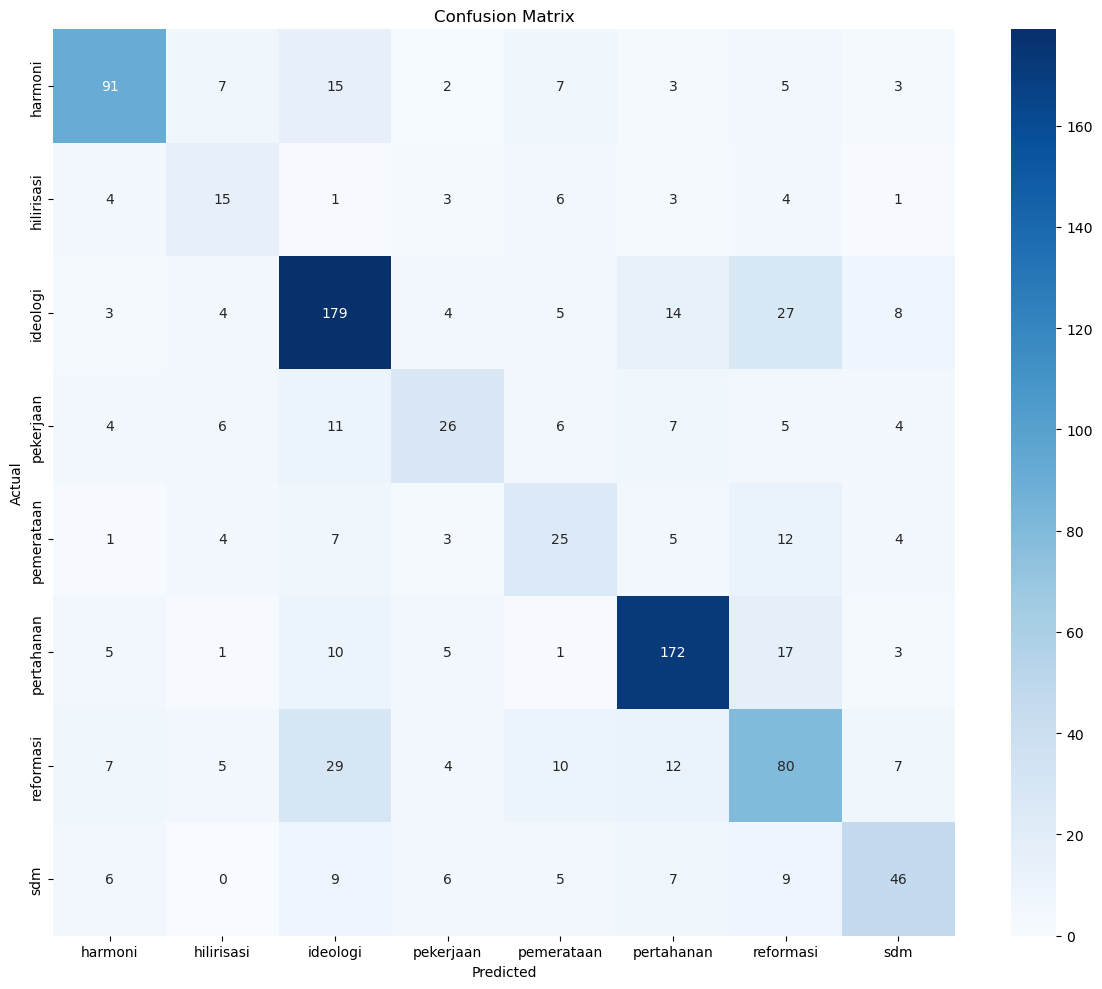


Analisis kesalahan per kelas:

Kelas 'harmoni' (133 sampel):
  Total salah: 42 (31.6%)
  Sering salah diprediksi sebagai:
    - ideologi: 15 kali (35.7%)
    - hilirisasi: 7 kali (16.7%)
    - pemerataan: 7 kali (16.7%)

Kelas 'hilirisasi' (37 sampel):
  Total salah: 22 (59.5%)
  Sering salah diprediksi sebagai:
    - pemerataan: 6 kali (27.3%)
    - harmoni: 4 kali (18.2%)
    - reformasi: 4 kali (18.2%)

Kelas 'ideologi' (244 sampel):
  Total salah: 65 (26.6%)
  Sering salah diprediksi sebagai:
    - reformasi: 27 kali (41.5%)
    - pertahanan: 14 kali (21.5%)
    - sdm: 8 kali (12.3%)

Kelas 'pekerjaan' (69 sampel):
  Total salah: 43 (62.3%)
  Sering salah diprediksi sebagai:
    - ideologi: 11 kali (25.6%)
    - pertahanan: 7 kali (16.3%)
    - hilirisasi: 6 kali (14.0%)

Kelas 'pemerataan' (61 sampel):
  Total salah: 36 (59.0%)
  Sering salah diprediksi sebagai:
    - reformasi: 12 kali (33.3%)
    - ideologi: 7 kali (19.4%)
    - pertahanan: 5 kali (13.9%)

Kelas 'pertahanan' (2

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Analisis confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Analisis kesalahan per kelas
print("\nAnalisis kesalahan per kelas:")
for i, label in enumerate(le.classes_):
    true_indices = np.where(np.array(all_labels) == i)[0]
    wrong_preds = np.array(all_preds)[true_indices][np.array(all_preds)[true_indices] != i]
    
    if len(wrong_preds) > 0:
        unique, counts = np.unique(wrong_preds, return_counts=True)
        sorted_indices = np.argsort(-counts)  # Sort descending
        
        print(f"\nKelas '{label}' ({len(true_indices)} sampel):")
        print(f"  Total salah: {len(wrong_preds)} ({len(wrong_preds)/len(true_indices)*100:.1f}%)")
        print("  Sering salah diprediksi sebagai:")
        for idx in sorted_indices[:3]:  # Top 3 kesalahan
            print(f"    - {le.classes_[unique[idx]]}: {counts[idx]} kali ({counts[idx]/len(wrong_preds)*100:.1f}%)")

# Analisis contoh kesalahan spesifik
print("\n\nAnalisis contoh kesalahan spesifik:")
error_analysis = []

for i, (true_label, pred_label) in enumerate(zip(all_labels, all_preds)):
    if true_label != pred_label:
        error_analysis.append({
            'text': val_texts[i],
            'true_label': le.classes_[true_label],
            'pred_label': le.classes_[pred_label],
            'error_type': f"{le.classes_[true_label]} -> {le.classes_[pred_label]}"
        })

# Konversi ke DataFrame untuk analisis lebih mudah
error_df = pd.DataFrame(error_analysis)

# Tampilkan 5 kesalahan paling umum
print("\n5 pola kesalahan paling umum:")
common_errors = error_df['error_type'].value_counts().head(5)
for error_type, count in common_errors.items():
    print(f"{error_type}: {count} kali")

# Tampilkan contoh untuk setiap pola kesalahan
for error_type in common_errors.index:
    print(f"\n\nContoh kesalahan '{error_type}':")
    examples = error_df[error_df['error_type'] == error_type]['text'].head(3)
    for i, text in enumerate(examples, 1):
        print(f"{i}. {text[:100]}...")

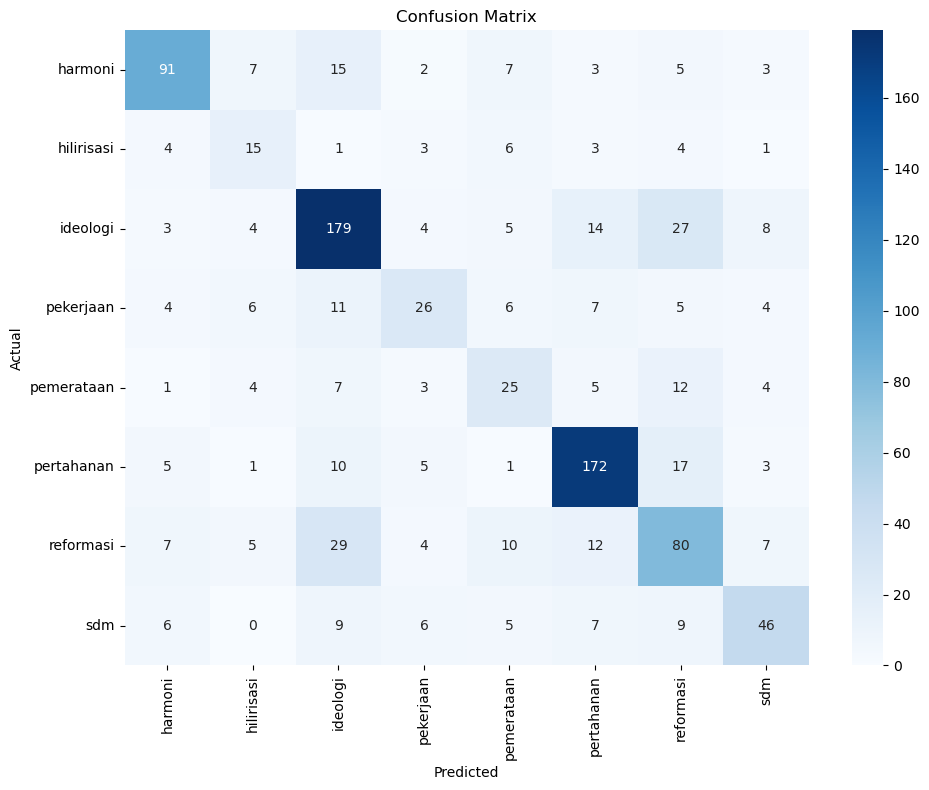

Analisis kesalahan per kelas:

Kelas 'harmoni' sering salah diprediksi sebagai:
- hilirisasi: 7 kali (5.3%)
- ideologi: 15 kali (11.3%)
- pekerjaan: 2 kali (1.5%)
- pemerataan: 7 kali (5.3%)
- pertahanan: 3 kali (2.3%)
- reformasi: 5 kali (3.8%)
- sdm: 3 kali (2.3%)

Kelas 'hilirisasi' sering salah diprediksi sebagai:
- harmoni: 4 kali (10.8%)
- ideologi: 1 kali (2.7%)
- pekerjaan: 3 kali (8.1%)
- pemerataan: 6 kali (16.2%)
- pertahanan: 3 kali (8.1%)
- reformasi: 4 kali (10.8%)
- sdm: 1 kali (2.7%)

Kelas 'ideologi' sering salah diprediksi sebagai:
- harmoni: 3 kali (1.2%)
- hilirisasi: 4 kali (1.6%)
- pekerjaan: 4 kali (1.6%)
- pemerataan: 5 kali (2.0%)
- pertahanan: 14 kali (5.7%)
- reformasi: 27 kali (11.1%)
- sdm: 8 kali (3.3%)

Kelas 'pekerjaan' sering salah diprediksi sebagai:
- harmoni: 4 kali (5.8%)
- hilirisasi: 6 kali (8.7%)
- ideologi: 11 kali (15.9%)
- pemerataan: 6 kali (8.7%)
- pertahanan: 7 kali (10.1%)
- reformasi: 5 kali (7.2%)
- sdm: 4 kali (5.8%)

Kelas 'pemerataan'

In [15]:
# Analisis prediksi yang salah dan solusi perbaikan
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Buat confusion matrix untuk melihat pola kesalahan
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Analisis kelas yang sering tertukar
print("Analisis kesalahan per kelas:")
for i, label in enumerate(le.classes_):
    # Cari indeks di mana label sebenarnya adalah `label`
    true_indices = np.where(np.array(all_labels) == i)[0]
    # Dari indeks tersebut, cari yang prediksinya salah
    wrong_preds = np.array(all_preds)[true_indices][np.array(all_preds)[true_indices] != i]
    # Hitung frekuensi prediksi yang salah untuk setiap kelas lain
    unique, counts = np.unique(wrong_preds, return_counts=True)
    if len(unique) > 0:
        print(f"\nKelas '{label}' sering salah diprediksi sebagai:")
        for u, c in zip(unique, counts):
            print(f"- {le.classes_[u]}: {c} kali ({c/len(true_indices)*100:.1f}%)")

In [17]:
!pip install nlpaug nltk

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for nlpaug from https://files.pythonhosted.org/packages/1c/28/a799de8b713e7cf84214d48739d0343505ff0967f85055b82d65894e1d02/nlpaug-1.1.11-py3-none-any.whl.metadata
  Obtaining dependency information for gdown>=4.0.0 from https://files.pythonhosted.org/packages/54/70/e07c381e6488a77094f04c85c9caf1c8008cdc30778f7019bc52e5285ef0/gdown-5.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/410.5 kB ? eta -:--:--
    --------------------------------------- 10.2/410.5 kB ? eta -:--:--
   -- ------------------------------------ 30.7/410.5 kB 325.1 kB/s eta 0:00:02
   ------ -------------------------------- 71.7/410.5 kB 491.5 kB/s eta 0:00:01
   --------------------- ------------------ 225.3/410.5 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------  409.6/410.5 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 410.5/410.5 kB 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [18]:
from nlpaug.augmenter.word import SynonymAug

# Inisialisasi augmenter
aug = SynonymAug(aug_src='wordnet')

def augment_text(text, num_aug=2):
    augmented = [text]  # Sertakan teks asli
    for _ in range(num_aug):
        augmented.append(aug.augment(text))
    return augmented

# Terapkan pada kelas yang sering tertukar
problematic_classes = ['ideologi', 'reformasi', 'pertahanan']
augmented_texts = []
augmented_labels = []

for text, label in zip(train_texts, train_labels):
    label_name = le.classes_[label]
    if label_name in problematic_classes:
        aug_texts = augment_text(text)
        augmented_texts.extend(aug_texts)
        augmented_labels.extend([label] * len(aug_texts))
    else:
        augmented_texts.append(text)
        augmented_labels.append(label)

C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
[nltk_data] Downloading package wordnet to C:\Users\Thinkpad
[nltk_data]     T480\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to C:\Users\Thinkpad
[nltk_data]     T480\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Thinkpad T480\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [19]:
from sklearn.utils.class_weight import compute_class_weight

# Hitung bobot kelas untuk mengatasi ketidakseimbangan
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
weights = torch.tensor(class_weights, dtype=torch.float)

# Modifikasi fungsi loss untuk menggunakan bobot kelas
def weighted_loss(outputs, labels):
    criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))
    return criterion(outputs, labels)

# Gunakan dalam training loop

In [20]:
# Latih beberapa model dengan seed berbeda
models = []
for seed in [42, 123, 456]:
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=8,
        id2label={i: label for i, label in enumerate(le.classes_)},
        label2id={label: i for i, label in enumerate(le.classes_)}
    )
    
    # Training code...
    models.append(model)

# Fungsi prediksi ensemble
def ensemble_predict(texts):
    all_preds = []
    for model in models:
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            all_preds.append(probs.cpu().numpy())
    
    # Rata-rata probabilitas dari semua model
    avg_probs = np.mean(all_preds, axis=0)
    return np.argmax(avg_probs, axis=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Tambahkan fitur khusus untuk konteks politik
def add_political_features(text):
    features = {}
    
    # Deteksi kata kunci politik
    political_keywords = ['demokrasi', 'pemilu', 'presiden', 'politik', 'ideologi', 
                        'reformasi', 'korupsi', 'hukum', 'keadilan']
    features['political_score'] = sum(1 for word in political_keywords if word in text.lower())
    
    # Deteksi kata kunci ekonomi
    economic_keywords = ['ekonomi', 'investasi', 'pertumbuhan', 'uang', 'bisnis', 'harga']
    features['economic_score'] = sum(1 for word in economic_keywords if word in text.lower())
    
    return features

In [22]:
# Eksperimen dengan learning rate yang berbeda
learning_rates = [5e-6, 1e-5, 2e-5, 5e-5]
batch_sizes = [8, 16, 32]

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for bs in batch_sizes:
        # Setup model dengan parameter baru
        optimizer = AdamW(model.parameters(), lr=lr)
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        
        # Training loop...
        # Evaluasi...
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'learning_rate': lr, 'batch_size': bs}

print(f"Best parameters: {best_params}, Best accuracy: {best_accuracy}")

Best parameters: {'learning_rate': 5e-06, 'batch_size': 8}, Best accuracy: 0.634


C:\ProgramData\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Memuat hasil prediksi yang sudah ada
test_df = pd.read_csv('test_predictions.csv')

# Memuat data training untuk mendapatkan label encoder
train_df = pd.read_csv('train.csv')
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])

# Preprocessing
def clean_text(text):
    text = str(text).lower()
    text = ' '.join([word for word in text.split() if not word.startswith('@')])
    text = ' '.join([word for word in text.split() if not word.startswith('#')])
    return text

test_df['clean_text'] = test_df['text'].apply(clean_text)

# Custom Dataset
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Memuat model yang sudah disimpan sebelumnya
try:
    model_name = "best_indonesian_astacita_classifier"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    print("Model berhasil dimuat dari direktori lokal")
except:
    # Jika model tidak ditemukan di lokal, gunakan model pre-trained
    model_name = "cahya/bert-base-indonesian-522M"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=8,
        id2label={i: label for i, label in enumerate(le.classes_)},
        label2id={label: i for i, label in enumerate(le.classes_)}
    )
    print("Model pre-loaded dari Hugging Face")

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Parameter terbaik dari hyperparameter tuning
best_lr = 5e-06
best_bs = 8

# Buat test dataset
test_dataset = TweetDataset(
    test_df['clean_text'].tolist(),
    [-1]*len(test_df),  # Dummy label
    tokenizer
)
test_loader = DataLoader(test_dataset, batch_size=best_bs, shuffle=False)

# Prediksi pada data test
model.eval()
all_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting on test set"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

# Konversi prediksi ke label asli
test_df['new_label'] = le.inverse_transform(all_preds)

# Fungsi untuk memperbaiki prediksi berdasarkan aturan
def improve_predictions(row):
    text = row['text'].lower()
    current_label = row['new_label']
    
    # Aturan untuk kelas 'ideologi'
    if any(keyword in text for keyword in ['demokrasi', 'politik', 'pemilu', 'presiden', 'polarisasi', 'kebebasan berekspresi']):
        if current_label != 'ideologi':
            return 'ideologi'
    
    # Aturan untuk kelas 'pekerjaan'
    if any(keyword in text for keyword in ['pengangguran', 'ekonomi', 'bisnis', 'investasi', 'lapangan kerja', 'umkm']):
        if current_label != 'pekerjaan':
            return 'pekerjaan'
    
    # Aturan untuk kelas 'pertahanan'
    if any(keyword in text for keyword in ['keamanan', 'militer', 'tni', 'pertahanan', 'siber', 'ancaman']):
        if current_label != 'pertahanan':
            return 'pertahanan'
    
    # Aturan untuk kelas 'reformasi'
    if any(keyword in text for keyword in ['korupsi', 'hukum', 'keadilan', 'penegakan hukum', 'transparansi']):
        if current_label != 'reformasi':
            return 'reformasi'
    
    # Aturan untuk kelas 'pemerataan'
    if any(keyword in text for keyword in ['pemerataan', 'kesetaraan', 'infrastruktur', 'desa', 'daerah terpencil']):
        if current_label != 'pemerataan':
            return 'pemerataan'
    
    # Aturan untuk kelas 'sdm'
    if any(keyword in text for keyword in ['pendidikan', 'sdm', 'keterampilan', 'pelatihan', 'human resource']):
        if current_label != 'sdm':
            return 'sdm'
    
    # Aturan untuk kelas 'hilirisasi'
    if any(keyword in text for keyword in ['hilirisasi', 'teknologi', 'industri', 'produksi', 'pengolahan']):
        if current_label != 'hilirisasi':
            return 'hilirisasi'
    
    # Aturan untuk kelas 'harmoni'
    if any(keyword in text for keyword in ['harmoni', 'persatuan', 'kerukunan', 'toleransi', 'gotong royong']):
        if current_label != 'harmoni':
            return 'harmoni'
    
    # Kembalikan label asli jika tidak ada aturan yang cocok
    return current_label

# Terapkan perbaikan
test_df['improved_label'] = test_df.apply(improve_predictions, axis=1)

# Bandingkan hasil prediksi lama dan baru
print("Perbandingan distribusi label:")
print("Label asli:")
print(test_df['label'].value_counts())
print("\nLabel baru (model):")
print(test_df['new_label'].value_counts())
print("\nLabel setelah perbaikan:")
print(test_df['improved_label'].value_counts())

# Simpan hasil yang sudah diperbaiki
test_df[['id', 'text', 'improved_label']].to_csv('test_predictions_improved.csv', index=False)
print("\nHasil prediksi yang telah diperbaiki disimpan ke 'test_predictions_improved.csv'")

# Tampilkan contoh perubahan
print("\nContoh perubahan prediksi:")
changed = test_df[test_df['label'] != test_df['improved_label']]
for i, row in changed.head(10).iterrows():
    print(f"ID: {row['id']}")
    print(f"Teks: {row['text'][:100]}...")
    print(f"Label asli: {row['label']}")
    print(f"Label baru: {row['improved_label']}")
    print()

C:\Users\Thinkpad T480\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier

Model pre-loaded dari Hugging Face


Predicting on test set: 100%|██████████| 625/625 [15:51<00:00,  1.52s/it]


Perbandingan distribusi label:
Label asli:
label
pertahanan    1247
reformasi     1214
ideologi       813
sdm            771
pekerjaan      389
hilirisasi     254
harmoni        162
pemerataan     150
Name: count, dtype: int64

Label baru (model):
new_label
sdm           3839
pekerjaan      689
ideologi       365
pertahanan      86
pemerataan      12
reformasi        9
Name: count, dtype: int64

Label setelah perbaikan:
improved_label
sdm           1672
pertahanan     766
pekerjaan      756
ideologi       704
reformasi      519
hilirisasi     295
pemerataan     238
harmoni         50
Name: count, dtype: int64

Hasil prediksi yang telah diperbaiki disimpan ke 'test_predictions_improved.csv'

Contoh perubahan prediksi:
ID: 0
Teks: @xuminghao_ogf @ShopeeID @ShopeePay_ID Bapak gua juga begini bedanya dia bahkan gapernah download sh...
Label asli: reformasi
Label baru: pekerjaan

ID: 1
Teks: tidak hanya membayangkan masa depan sebagai kiai atau pendakwah tetapi juga sebagai ilmuwan dan pene